In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
import deepxde.deepxde.backend as bkd
from datasets import makeTesting
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H:%M:%S", time.localtime())

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
if False:
    makeTesting()

In [3]:
class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value
    
    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [4]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

In [5]:
space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(20), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = 3)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load("datasets/DF_100_0.1_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [6]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [7]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = boundary_losses)

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 128, 128, 128],
    [5, 128, 128, 128],
    "gelu",
    "Glorot normal",
)

net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", lr=1E-3, loss= ["mse"], metrics = ["mean l2 relative error"])


Compiling model...
'compile' took 0.000252 s



Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.42e-02, 0.00e+00, 0.00e+00]    [2.12e-01, 0.00e+00, 0.00e+00]    [1.04e+00]    
1000      [1.02e-02, 0.00e+00, 0.00e+00]    [3.50e-02, 0.00e+00, 0.00e+00]    [4.18e-01]    

Best model at step 1000:
  train loss: 1.02e-02
  test loss: 3.50e-02
  test metric: [4.18e-01]

'train' took 11.937446 s



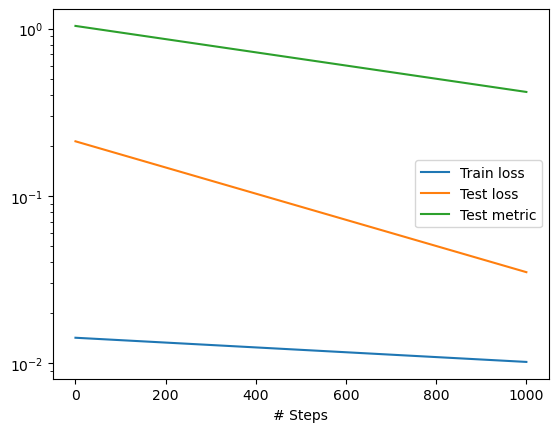

In [8]:
losshistory, train_state = model.train(iterations=1000, batch_size = 1)
dde.utils.plot_loss_history(losshistory)

In [9]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}.csv")

In [10]:

while len(train_vxs) < 1000:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = 0.1, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, 1000, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    out = model.predict(a, aux_vars = c, operator = pde)
    
    res = np.mean(np.abs(out), axis = 1)
    print(np.mean(res), np.std(res))
    topk_index = np.argpartition(res, -20)[-20:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = 6)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = boundary_losses)
    
    model = dde.Model(data, net)
    batchsize = len(train_vxs) // 10
    model.compile("adam", 
                  lr=1e-3, 
                  metrics = ["mean l2 relative error"], 
                  decay = ("inverse time", 4000, 0.5))
    losshistory, train_state = model.train(iterations=20000, batch_size = batchsize)
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}.csv"), pd_frame], axis = 0)
    pd_frame.to_csv(f"results/loss_history_{date}.csv")
    dde.utils.plot_loss_history(losshistory)


0.48291406 0.1606446
40
Compiling model...
'compile' took 0.000365 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.92e-02, 0.00e+00, 0.00e+00]    [3.50e-02, 0.00e+00, 0.00e+00]    [4.18e-01]    
1000      [3.25e-03, 0.00e+00, 0.00e+00]    [9.15e-03, 0.00e+00, 0.00e+00]    [2.34e-01]    


KeyboardInterrupt: 